In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import aplpy

In [3]:
data=fits.open(r'C:\Users\DEEPMALYA\OneDrive\Desktop\pip_Malya\Python\ML\HorseHead.fits')

In [4]:
data

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000021FFFC4D7F0>, <astropy.io.fits.hdu.table.TableHDU object at 0x0000021FFFC4EE40>]

In [5]:
data.info()

Filename: C:\Users\DEEPMALYA\OneDrive\Desktop\pip_Malya\Python\ML\HorseHead.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


In [6]:
img1=data[0].data
img2=data[1].data

In [28]:
img1

array([[ 7201,  6642,  6642, ...,  9498,  9498, 10057],
       [ 6642,  6363,  6642, ..., 10057, 10616, 10616],
       [ 6922,  6642,  6922, ..., 10337, 11175, 10616],
       ...,
       [ 5412,  5132,  5412, ..., 13000, 12580, 12021],
       [ 5796,  5517,  5796, ..., 12546, 12546, 11987],
       [ 5796,  5796,  6076, ..., 11987, 12546, 12546]],
      shape=(893, 891), dtype='>i2')

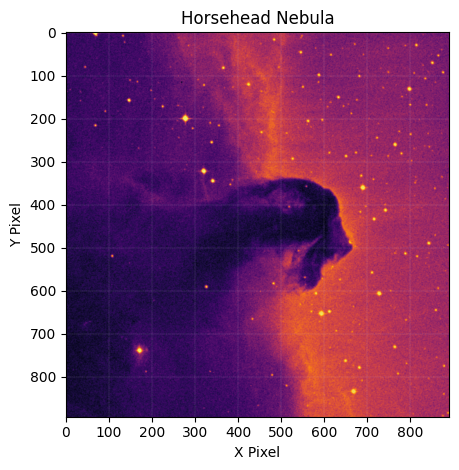

In [30]:
plt.grid(True, color='white', linestyle='--', linewidth=0.09)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title('Horsehead Nebula')

plt.tight_layout()
plt.imshow(img1,cmap='inferno')

In [ ]:
img2

FITS_rec([(np.float64(-3.12), np.float64(-3.12), np.float64(0.09), np.float64(0.04)),
          (np.float64(-2.96), np.float64(-3.12), np.float64(0.02), np.float64(0.07)),
          (np.float64(-2.8), np.float64(-3.12), np.float64(-0.07), np.float64(0.15)),
          ...,
          (np.float64(2.8), np.float64(3.12), np.float64(0.0), np.float64(0.0)),
          (np.float64(2.96), np.float64(3.12), np.float64(0.0), np.float64(0.0)),
          (np.float64(3.12), np.float64(3.12), np.float64(0.0), np.float64(0.0))],
         dtype=(numpy.record, [('XI', 'S6'), ('ETA', 'S6'), ('XI_CORR', 'S6'), ('ETA_CORR', 'S6')]))

## **Creating an artificial image**

In [ ]:
import os

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from photutils.aperture import EllipticalAperture

In [ ]:
# Set up the random number generator, allowing a seed to be set from the environment
seed = os.getenv('GUIDE_RANDOM_SEED', None)

if seed is not None:
    seed = int(seed)
    
# This is the generator to use for any image component which changes in each image, e.g. read noise
# or Poisson error
noise_rng = np.random.default_rng(seed)

In [ ]:
from Graphics.astropy_basics.convenience_functions import show_image # helper file to properly display images in a notebook

## Start: a blank image

In [ ]:
synthetic_image = np.zeros([1000, 1000])

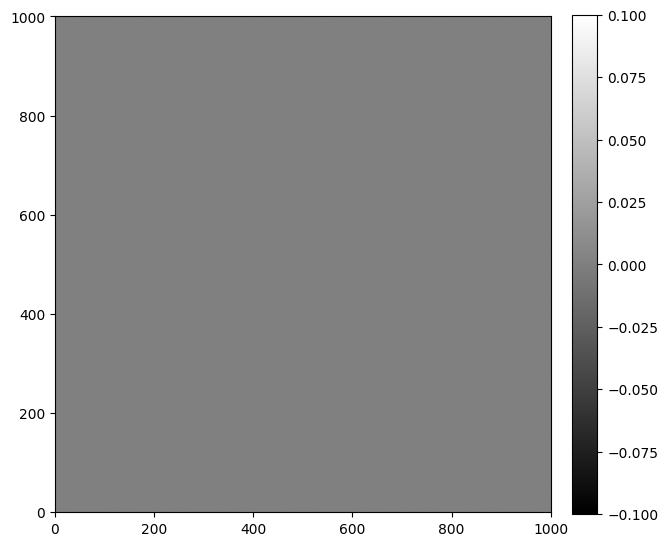

In [ ]:
show_image(synthetic_image, cmap='gray',figsize=(7,7))

## . Add some read noise

In [ ]:
def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape
    
    noise = noise_rng.normal(scale=amount/gain, size=shape)
    
    return noise

<Figure size 640x480 with 0 Axes>

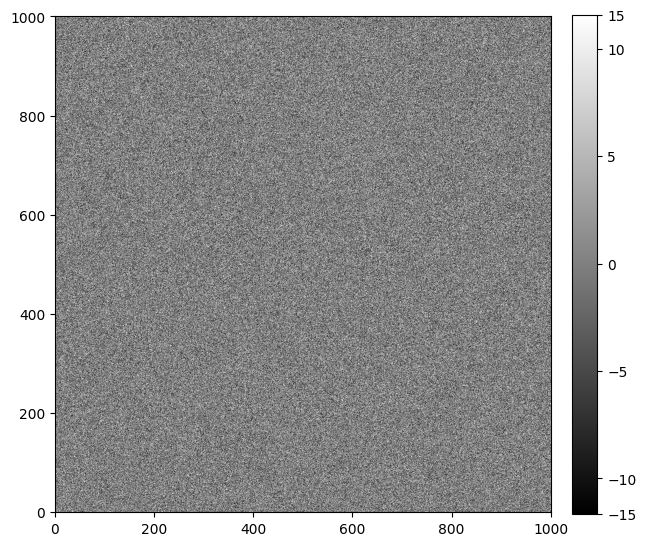

In [ ]:
plt.figure()
noise_im = synthetic_image + read_noise(synthetic_image, 5)
show_image(noise_im, cmap='gray',figsize=(7,7))

## Bias

Bias is an offset voltage (which translates into some non-zero number of counts) added to every pixel in the image to ensure that when voltages are converted to counts there is never a negative count.

In [ ]:
def bias(image, value, realistic=False):
    """
    Generate simulated bias image.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the bias array should match.
    value: float
        Bias level to add.
    realistic : bool, optional
        If ``True``, add some columns with somewhat higher bias value (a not uncommon thing)
    """
    # This is the whole thing: the bias is really suppose to be a constant offset!
    bias_im = np.zeros_like(image) + value
    
    # If we want a more realistic bias we need to do a little more work. 
    if realistic:
        shape = image.shape
        number_of_colums = 5
        
        # We want a random-looking variation in the bias, but unlike the readnoise the bias should 
        # *not* change from image to image, so we make sure to always generate the same "random" numbers.
        rng = np.random.RandomState(seed=8392)  # 20180520
        columns = rng.randint(0, shape[1], size=number_of_colums)
        # This adds a little random-looking noise into the data.
        col_pattern = rng.randint(0, int(0.1 * value), size=shape[0])
        
        # Make the chosen columns a little brighter than the rest...
        for c in columns:
            bias_im[:, c] = value + col_pattern
            
    return bias_im
        

Text(0.5, 1.0, 'Bias alone, bad columns included')

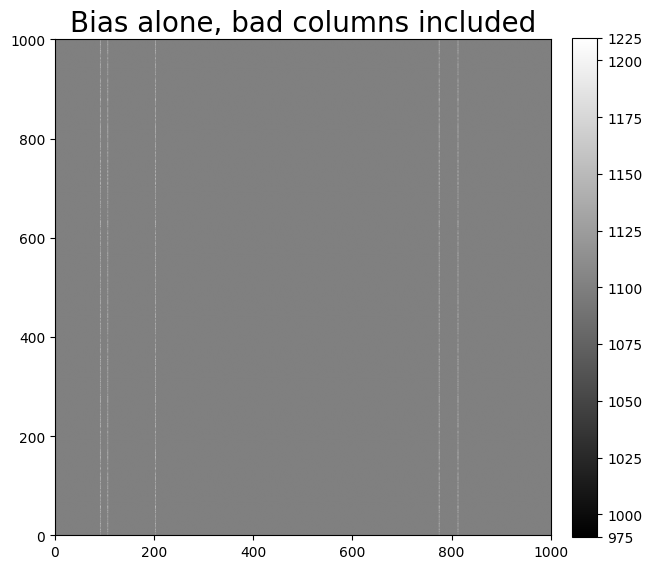

In [ ]:
bias_only = bias(synthetic_image, 1100, realistic=True)
show_image(bias_only, cmap='gray', figsize=(7, 7))
plt.title('Bias alone, bad columns included', fontsize='20')

### Noise + Bias stage

Text(0.5, 1.0, 'Realistic bias frame (includes read noise)')

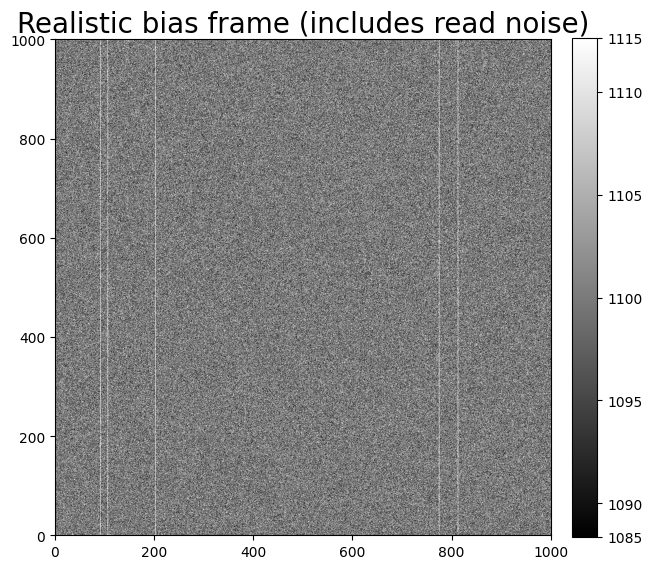

In [ ]:
bias_noise_im = noise_im + bias_only
show_image(bias_noise_im, cmap='gray', figsize=(7, 7))
plt.title('Realistic bias frame (includes read noise)', fontsize='20')

## Dark current

Dark current is defined as the relatively small electric current that flows through photosensitive devices like photodiodes, even when no photons are entering the device. This current arises from the thermal generation of electron-hole pairs within the semiconductor material, particularly in the depletion region of the photodiode

In [ ]:
def dark_current(image, current, exposure_time, gain=1.0, hot_pixels=False):
    """
    Simulate dark current in a CCD, optionally including hot pixels.
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    current : float
        Dark current, in electrons/pixel/second, which is the way manufacturers typically 
        report it.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    strength : float, optional
        Pixel count in the cosmic rays.    
    """
    
    # dark current for every pixel; we'll modify the current for some pixels if 
    # the user wants hot pixels.
    base_current = current * exposure_time / gain
    
    # This random number generation should change on each call.
    dark_im = noise_rng.poisson(base_current, size=image.shape)
        
    if hot_pixels:
        # We'll set 0.01% of the pixels to be hot; that is probably too high but should 
        # ensure they are visible.
        y_max, x_max = dark_im.shape
        
        n_hot = int(0.0001 * x_max * y_max)
        
        # Like with the bias image, we want the hot pixels to always be in the same places
        # (at least for the same image size) but also want them to appear to be randomly
        # distributed. So we set a random number seed to ensure we always get the same thing.
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)
        
        hot_current = 10000 * current
        
        dark_im[(hot_y, hot_x)] = hot_current * exposure_time / gain
    return dark_im

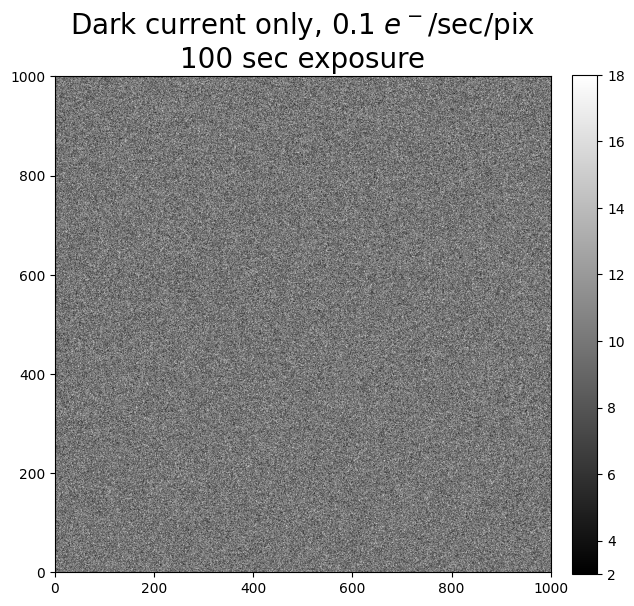

In [ ]:
dark_exposure = 100
dark_cur = 0.1
dark_only = dark_current(synthetic_image, dark_cur, dark_exposure, hot_pixels=True)
show_image(dark_only, cmap='gray',figsize=(7,7))
title_string = 'Dark current only, {dark_cur} $e^-$/sec/pix\n{dark_exposure} sec exposure'.format(dark_cur=dark_cur, dark_exposure=dark_exposure)
plt.title(title_string, fontsize='20');

 Integrated stage

Text(0.5, 1.0, 'Realistic dark frame \n(with bias, read noise)')

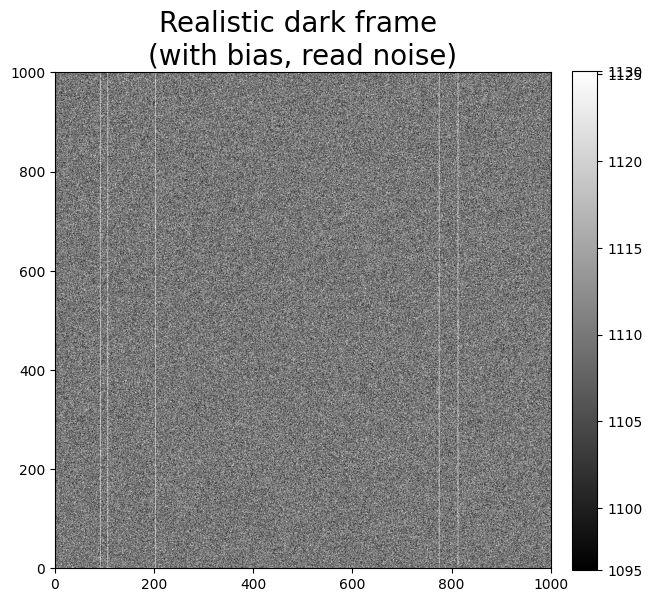

In [ ]:
dark_bias_noise_im = bias_noise_im + dark_only
show_image(dark_bias_noise_im, cmap='gray',figsize=(7,7))
plt.title('Realistic dark frame \n(with bias, read noise)', fontsize='20')

## Sky background

In [ ]:
def sky_background(image, sky_counts, gain=1):
    """
    Generate sky background, optionally including a gradient across the image (because
    some times Moons happen).
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    sky_counts : float
        The target value for the number of counts (as opposed to electrons or 
        photons) from the sky.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    sky_im = noise_rng.poisson(sky_counts * gain, size=image.shape) / gain
    
    return sky_im

Text(0.5, 1.0, 'Sky background only, 20 counts input')

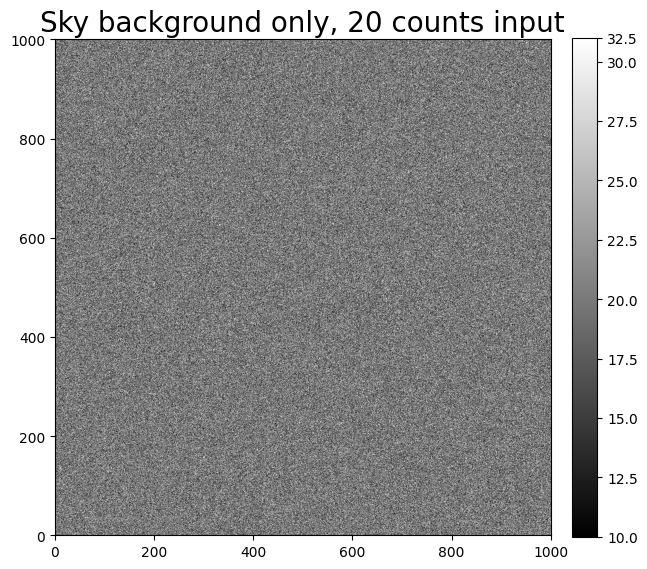

In [ ]:
sky_level = 20
sky_only = sky_background(synthetic_image, sky_level)
show_image(sky_only, cmap='gray',figsize=(7,7))
plt.title('Sky background only, {} counts input'.format(sky_level), fontsize=20)

Text(0.5, 1.0, 'Sky, dark, bias and noise\n(Realistic image of clouds)')

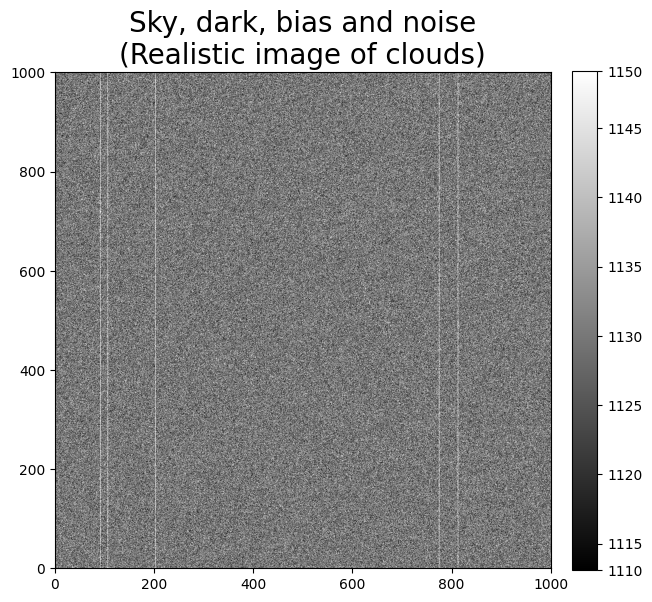

In [ ]:
sky_dark_bias_noise_im = dark_bias_noise_im + sky_only
show_image(sky_dark_bias_noise_im, cmap='gray',figsize=(7,7))
plt.title('Sky, dark, bias and noise\n(Realistic image of clouds)', fontsize=20)

## Interactive layer

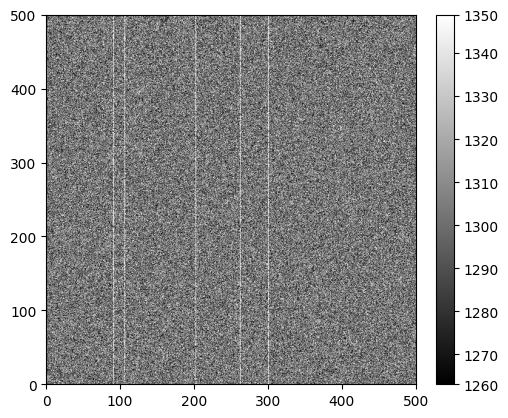

In [ ]:
from ipywidgets import interactive, interact

# @interact(bias_level=(1000,1200,10), dark=(0.01,1,0.01), sky_counts=(0, 300, 10),
#           gain=(0.5, 3.0, 0.1), read=(0, 50, 2.0),
#           exposure=(0, 300, 10))
def complete_image(bias_level=1100, read=10.0, gain=1, dark=0.1, 
                   exposure=30, hot_pixels=True, sky_counts=200):
    synthetic_image = np.zeros([500, 500])
    show_image(synthetic_image + 
               read_noise(synthetic_image, read) +
               bias(synthetic_image, bias_level, realistic=True) + 
               dark_current(synthetic_image, dark, exposure, hot_pixels=hot_pixels) +
               sky_background(synthetic_image, sky_counts),
               cmap='gray',
               figsize=None)
    
i = interactive(complete_image, bias_level=(1000,1200,10), dark=(0.0,1,0.1), sky_counts=(0, 300, 50),
          gain=(0.5, 3.0, 0.25), read=(0, 50, 5.0),
          exposure=(0, 300, 30))

for kid in i.children:
    try:
        kid.continuous_update = False
    except KeyError:
        pass
#i

In [ ]:
def stars(image, number, max_counts=10000, gain=1):
    """
    Add some stars to the image.
    """
    from photutils.datasets import make_model_image, make_model_params
    from photutils.psf import CircularGaussianPSF

    psf_model = CircularGaussianPSF(fwhm=9.4)
    max_counts *= 100  # approx. peak amplitude to flux
    params = make_model_params(image.shape, n_sources=number,
                               flux=(max_counts / 10, max_counts),
                               min_separation=20,
                               border_size=20, seed=12345)

    return make_model_image(image.shape, psf_model, params,
                            progress_bar=True)

Add model sources:   0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Stars only')

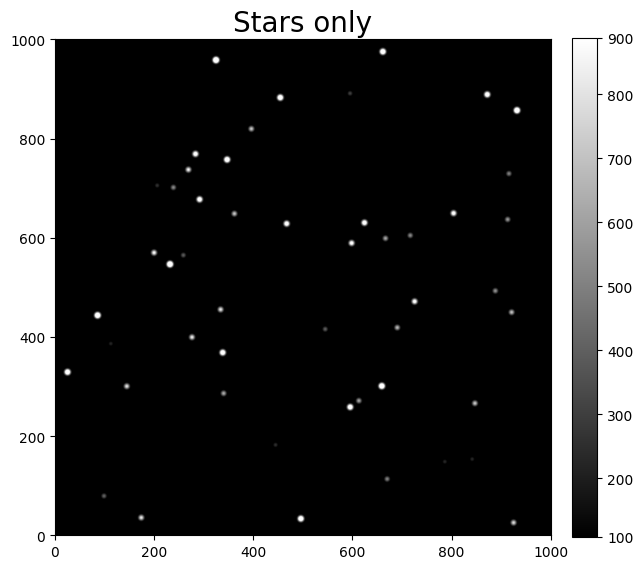

In [ ]:
stars_only = stars(synthetic_image, 50, max_counts=2000)
show_image(stars_only, cmap='gray', percu=99.9,figsize=(7,7))
plt.title('Stars only'.format(stars_only), fontsize=20)

In [ ]:
stars_with_background = sky_dark_bias_noise_im + stars_only

Text(0.5, 1.0, 'Stars with noise, bias, dark, sky')

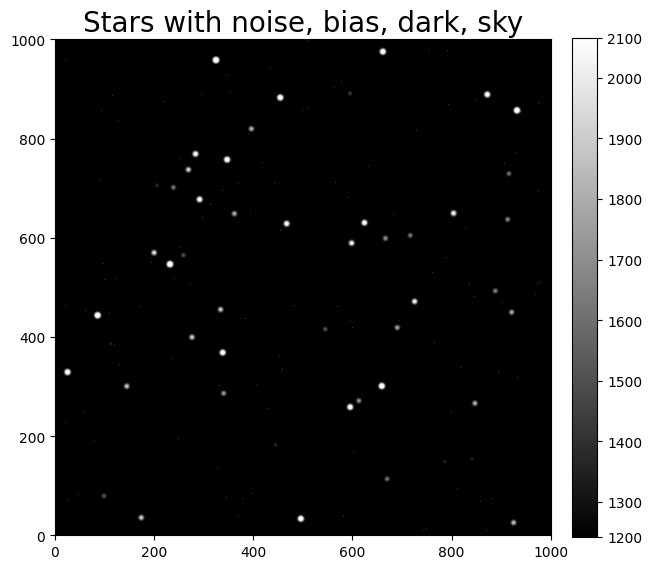

In [ ]:
show_image(stars_with_background, cmap='gray', percu=99.9,figsize=(7,7))
plt.title('Stars with noise, bias, dark, sky'.format(stars_with_background), fontsize=20)

## Summary

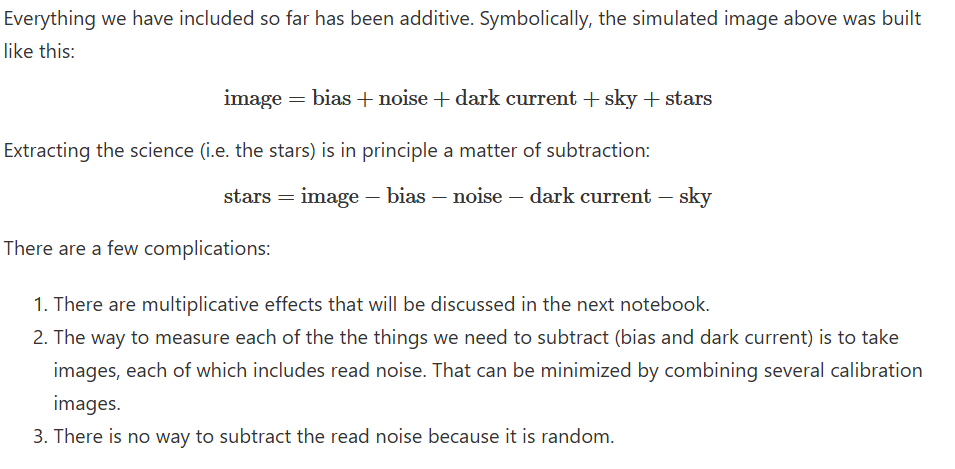